# Brain MNIST Classification
In this data set we will be using the MindBigData dataset (https://mindbigdata.com/opendb/index.html). I will be solely using just the MindWave file. This dataset contains EEG data when a person is shown a digit (0-9). The goal is to classify based on EEG data what digit was shown to the person.

## Importing Dataset

In [5]:
#importing dataset with pandas
import pandas as pd

data=pd.read_csv("MW.txt", sep='\t', header=None, names=["id", "event", "channel", "num", "size", "eeg"])

#plotting top 5 samples
data.head()

,id,event,channel,num,size,eeg
0,0,MW,FP1,0,1017,"38,48,51,44,48,56,56,41,20,-3,-9,-1,6,5,6,17,2..."
1,1,MW,FP1,1,889,"83,74,65,65,66,55,43,25,18,20,26,33,41,38,28,3..."
2,2,MW,FP1,4,1017,"19,10,-2,-9,-5,3,8,7,8,2,-10,-21,-22,-27,-30,-..."
3,3,MW,FP1,1,1017,"17,29,36,26,21,17,17,13,17,21,25,26,20,5,-5,-1..."
4,4,MW,FP1,8,952,"77,74,69,70,76,75,76,75,67,66,76,93,98,82,55,3..."


## Preprocessing the EEG Data

### Looking at the sizes of samples within data

In [6]:
#looking at the different sizes of data
data["size"].value_counts()

size
952     14403
953     13610
1024    12701
1017     8825
1015     8617
889      6445
951      1068
1016      820
1014      597
888       530
825         7
826         5
763         2
504         1
441         1
569         1
890         1
700         1
Name: count, dtype: int64

In [7]:
max_size = data["size"].max()

The dataset should contain 2 seconds of data with a sampling rate of 512Hz. Theoretically, there should be about 1024 samples of data. This is not the case when looking at the different sizes within the size column. To make further processing of the data it easier, I will pad the signals with less than 1024 samples with zeros.

## Extracting the EEG data from the Pandas Dataframe

In [8]:
import numpy as np

#preallocating array
eeg_data = np.zeros(shape=(max_size, data["eeg"].size))

#moving the array of strings to a temp variable
temp = data["eeg"].to_numpy()

#iterating through preallocated array
for i in range(data["eeg"].size):
    #calculating number of zeros to be padded
    num_pads = max_size - data["size"][i]
    #converting from string to array and removing commas
    temp_array = np.fromstring(temp[i], dtype=int, sep=',')
    #padding array
    eeg_data[:,i] = np.pad(temp_array, (0,num_pads), 'constant', constant_values=(0))

#transposing so samples are among the columns
eeg_data = np.transpose(eeg_data)
eeg_data.shape

(67635, 1024)

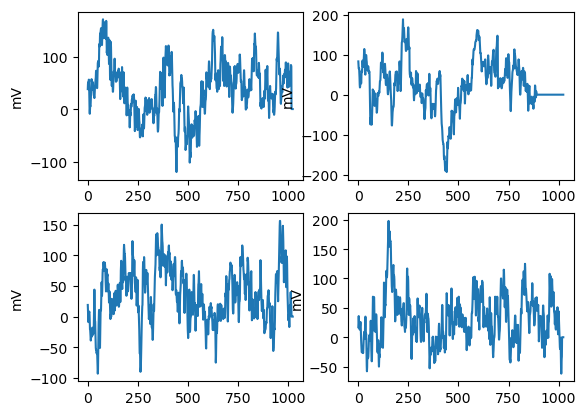

In [9]:
#plotting some eeg data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2)

i=0;
for ax in ax.flat:
    ax.plot(eeg_data[i,:])
    ax.set(ylabel='mV')
    i+=1

### Train-Test Split
Before we perform any pre-processing on the raw eeg data, it is important to split the dataset within training and testing split to reduce the likelihood of data leakage.

In [10]:
#sklearn train-test split
from sklearn.model_selection import train_test_split

#extract labels from pandas dataframe
labels = data["num"].to_numpy()

#making training and testing data and labels with a stratified split
eeg_train, eeg_test, labels_train, labels_test = train_test_split(
                                                    eeg_data,
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=24,
                                                    stratify=labels)

eeg_train.shape, eeg_test.shape, labels_train.shape, labels_test.shape

((54108, 1024), (13527, 1024), (54108,), (13527,))

### Filtering the EEG Data / Spectral Analysis

Within EEG recordings, multiple types of brain waves reside in different frequency bands. The bandwidth of information that is important is within 0-100 Hz. Filtering out frequencies above 100 Hz can eliminate noise irrelevant to EEG information. The sampling frequency is 512 Hz, because of the Nyquist Theorem there is frequency information that can be seen up to 256Hz.

![image](figures\brain_wave_freqs.png)

Before we filter the data, it may be beneficial to look at the frequency spectrum to see what the frequency components are like. I will perform a 1024pt fft which is a one to one mapping between the time and frequency domain.

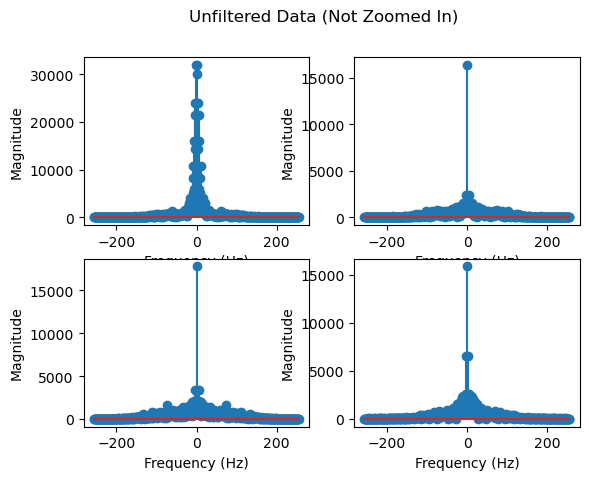

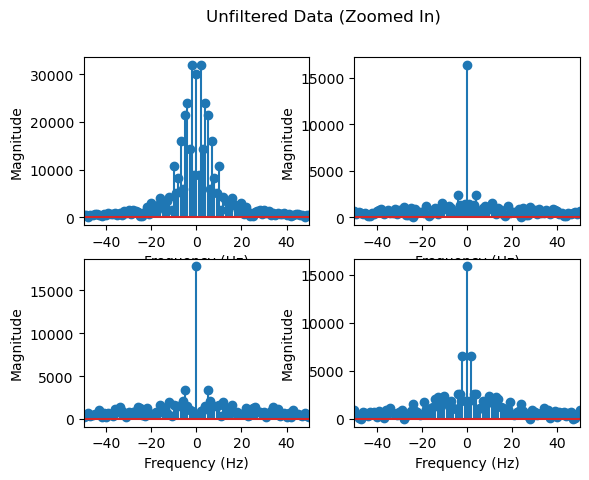

In [61]:
#plotting the frequency spectrum
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift, fftfreq

fig, ax = plt.subplots(2, 2)

i=0;
fs = 512;
fft_size = 512;
for ax in ax.flat:
    fig.suptitle("Unfiltered Data (Not Zoomed In)")
    fft_eeg = fftshift(fft(eeg_train[i,:],fft_size))
    fft_freq = fftshift(fftfreq(fft_size, 1/fs))
    ax.stem(fft_freq,np.abs(fft_eeg))
    ax.set(xlabel = 'Frequency (Hz)', ylabel='Magnitude')
    i+=1

fig, ax = plt.subplots(2, 2)

i=0;
fs = 512;
fft_size = 512;
for ax in ax.flat:
    fig.suptitle("Unfiltered Data (Zoomed In)")
    fft_eeg = fftshift(fft(eeg_train[i,:],fft_size))
    fft_freq = fftshift(fftfreq(fft_size, 1/fs))
    ax.stem(fft_freq,np.abs(fft_eeg))
    ax.set(xlabel = 'Frequency (Hz)', ylabel='Magnitude')
    ax.set_xlim([-50,50])
    i+=1

When looking at the frequency spectrum we see that we get frequency components to -256 Hz and 256 Hz. In the bottom plot, I show the components that will be most useful to us.

In [82]:
from scipy.signal import butter, lfilter

#creating low pass filter by obtaining fir coefficients using butterworth filter
cutoff_freq = 30
order = 3
b,a = butter(order,cutoff_freq, fs=fs)

#filtering the data
filtered_train = [lfilter(b, a, x) for x in eeg_train]
filtered_train = np.array(filtered_train)

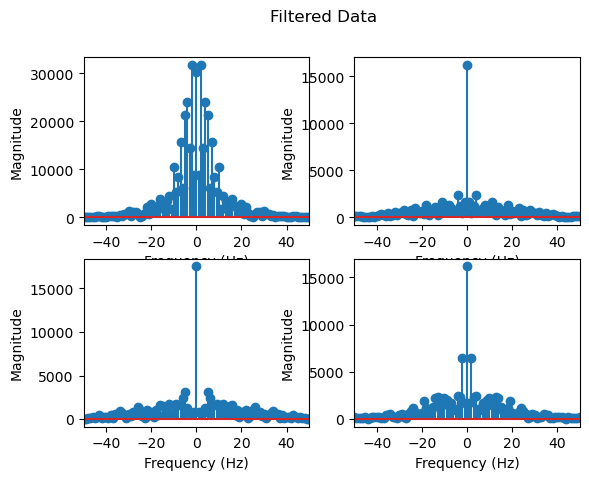

In [83]:
#plotting the filtered data
fig, ax = plt.subplots(2, 2)
i=0;
fs = 512;
fft_size = 512;
for ax in ax.flat:
    fig.suptitle("Filtered Data")
    fft_eeg = fftshift(fft(filtered_train[i,:],fft_size))
    fft_freq = fftshift(fftfreq(fft_size, 1/fs))
    ax.stem(fft_freq,np.abs(fft_eeg))
    ax.set(xlabel = 'Frequency (Hz)', ylabel='Magnitude')
    ax.set_xlim([-50,50])
    i+=1

Comparing the Unfiltered data to the Filtered data there is a bit better difference with less noise towards the end of the frequency spectrum